In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import sympy as sp
import h5py
import fcs_demo as fcs
from scipy import signal

In [4]:
contrast_values = 0.05
counts_values = 50.0
FWHM = 0.001 #GHz
tau = 500 #us
amp = 0.5

time = np.linspace(0.0, 5e04, 5001)
x_range = np.linspace(2.7, 3.0, time.size) #GHz

Text(0.5, 1.0, 'photon trajectory')

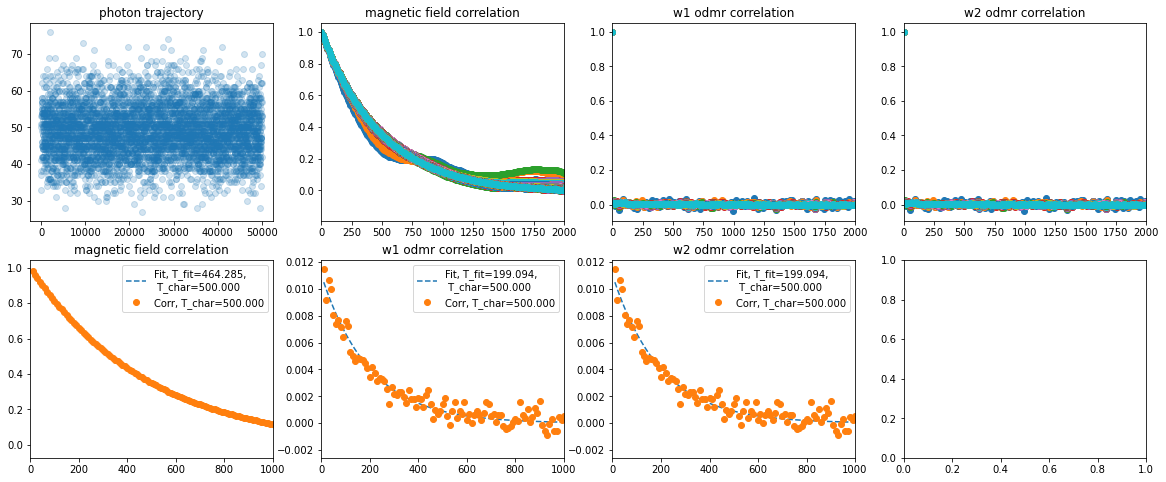

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=False, sharey=False)

itr = 1000

acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2, autocorr_mag_data, autocorr_odmr_data1, autocorr_odmr_data2, noisy_odmr_autocorr_1, noisy_odmr_autocorr_2, photon_trajectory, noisy_w_1_array, noisy_w_2_array = fcs.arrays(itr, time)

freq_1, freq_2 = fcs.freq_point(x_range, FWHM) 


for w in range(itr):

    noisy_w_1, noisy_w_2, noisy_mag_fields, noisy_w_1_array, noisy_w_2_array = fcs.freq_func(itr, tau, time, amp, noisy_w_1_array, noisy_w_2_array, w)

    noise_odmr_spectrum, noise_noisy_odmr_spectrum = fcs.simulate_ODMR(freq_1, 
                                                                    FWHM, np.asarray(noisy_w_1_array[w, :]), FWHM, np.asarray(noisy_w_2_array[w, :]), contrast_values, counts_values) # you can pass the array directly to the function to avoid another nested loop
                                                                                                                    
                                                                                                                                        # and we only need to calculate the count rate at one frequency
    photon_trajectory[w, :] = np.asarray(noise_noisy_odmr_spectrum)

    acf_norm_mag, acf_norm_odmr1, acf_norm_odmr2 = fcs.corr_analysis(noisy_mag_fields, time, photon_trajectory, w, 
                  autocorr_mag_data, autocorr_odmr_data1, autocorr_odmr_data2, 
                  acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2)




    axes[0, 1].plot(time, acf_norm_mag, 'o')
    axes[0, 1].set_title('magnetic field correlation')

    axes[0, 2].plot(time, acf_norm_odmr1, 'o')
    axes[0, 2].set_title('w1 odmr correlation')
    
    axes[0, 3].plot(time, acf_norm_odmr2, 'o')
    axes[0, 3].set_title('w2 odmr correlation')

axes[0, 1].set_xlim(0,2000)
axes[0, 2].set_xlim(0,2000)
axes[0, 3].set_xlim(0,2000)


average_mag_array, average_odmr_array1, average_odmr_array2, avg_noisy_mag_autocorr_fit, avg_noisy_odmr_autocorr_fit1, avg_noisy_odmr_autocorr_fit2 = fcs.avg_corr_analysis(acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2, tau, time)


axes[1, 0].plot(time[1:], avg_noisy_mag_autocorr_fit.best_fit, '--', label = f"Fit, T_fit={avg_noisy_mag_autocorr_fit.params['e_decay'].value:.3f}, \n T_char={tau:.3f}")
axes[1, 0].plot(time[1:], average_mag_array[1:], 'o', label = f'Corr, T_char={tau:.3f}')
axes[1, 0].set_title('magnetic field correlation')
axes[1, 0].legend()

axes[1, 1].plot(time[1:], avg_noisy_odmr_autocorr_fit1.best_fit, '--', label = f"Fit, T_fit={avg_noisy_odmr_autocorr_fit1.params['e_decay'].value:.3f}, \n T_char={tau:.3f}")
axes[1, 1].plot(time[1:], average_odmr_array1[1:], 'o', label = f'Corr, T_char={tau:.3f}')
axes[1, 1].set_title('w1 odmr correlation')
axes[1, 1].legend()

axes[1, 2].plot(time[1:], avg_noisy_odmr_autocorr_fit2.best_fit, '--', label = f"Fit, T_fit={avg_noisy_odmr_autocorr_fit2.params['e_decay'].value:.3f}, \n T_char={tau:.3f}")
axes[1, 2].plot(time[1:], average_odmr_array2[1:], 'o', label = f'Corr, T_char={tau:.3f}')
axes[1, 2].set_title('w2 odmr correlation')
axes[1, 2].legend()

axes[1, 0].set_xlim(0,1000)
axes[1, 1].set_xlim(0,1000)
axes[1, 2].set_xlim(0,1000)
      
axes[0, 0].plot(time, photon_trajectory[0,:], 'o', alpha = 0.2)
axes[0, 0].set_title('photon trajectory')
        


In [19]:
hf.close()

hf = h5py.File('data.h5', 'w')
hf.create_dataset('contrast_values', data=contrast_values)
hf.create_dataset('counts_values', data=counts_values)
hf.create_dataset('FWHM_values', data=FWHM)
hf.create_dataset('tau_values', data=tau)
hf.create_dataset('amplitude_values', data=amp)
hf.create_dataset('freq_1', data = noisy_w1)
hf.create_dataset('freq_2', data = noisy_w2)
hf.create_dataset('freq_1_pos', data=freq_1)
hf.create_dataset('freq_2_pos', data=freq_2)
hf.create_dataset('mag_autocorrelation', data = stacked_mag_arrays)
hf.create_dataset('odmr_autocorrelation_1', data = stacked_odmr_arrays1)
hf.create_dataset('odmr_autocorrelation_2', data = stacked_odmr_arrays2)
hf.create_dataset('average_magfield_autocorrelaiton', data = average_mag_array)
hf.create_dataset('average_magfield_autocorrelaiton_fit', data = avg_noisy_mag_autocorr_fit.best_fit)
hf.create_dataset('average_odmr_autocorrelaiton_1', data = average_odmr_array1)
hf.create_dataset('average_odmr_autocorrelaiton_2', data = average_odmr_array2)
hf.create_dataset('average_odmr_autocorrelaiton_fit_1', data = avg_noisy_odmr_autocorr_fit1.best_fit)
hf.create_dataset('average_odmr_autocorrelaiton_fit_2', data = avg_noisy_odmr_autocorr_fit2.best_fit)
hf.close()



In [23]:
hf.close()

hf = h5py.File('data.h5', 'r')
hf.keys()
FWHM = hf.get('FWHM_values')
print(FWHM)

hf.close()

<HDF5 dataset "FWHM_values": shape (1,), type "<f8">
